# Image colorization project

In [335]:
import gc
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from skimage import color
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, InputLayer, Activation, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Conv2DTranspose, Dense, Concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda, LeakyReLU, Cropping2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import mse
from keras import backend as K


from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import LSTM

# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
!pip freeze > requirements.txt

In [2]:
np.random.seed(1)

# Data Preparation

## Dataloader

In [426]:
class GenericDataLoader:
    def __init__(self, img_size=(32, 32), test_size=0.2, batch_size=32, augmentation=False):
        self.img_size = img_size
        self.test_size = test_size
        self.batch_size = batch_size
        self.train_data = []
        self.val_data = []
        self.augmentation = augmentation

        self.augmentation_params = dict(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.2
        )
        self._load_data()

    def _load_data(self):
        raise NotImplementedError()

    def _preprocess_image(self, img):
        raise NotImplementedError()

    def apply_augmentation(self, images):
        datagen = ImageDataGenerator(**self.augmentation_params)
        augmented_images = []
        for img in images:
            augmented_img = datagen.random_transform(img)
            augmented_images.append(augmented_img)
        return augmented_images

    def _data_generator(self, data):
        while True:
            np.random.shuffle(data)
            for start in range(0, len(data), self.batch_size):
                end = min(start + self.batch_size, len(data))
                batch = data[start:end]
                batch_x = []
                batch_y = []
                for img in batch:
                    img_x, img_y = self._preprocess_image(img)
                    batch_x.append(img_x)
                    batch_y.append(img_y)
                yield np.array(batch_x), np.array(batch_y)

    def get_train_generator(self):
        return self._data_generator(self.train_data)

    def get_val_generator(self):
        return self._data_generator(self.val_data)

    def get_train_steps(self):
        return len(self.train_data) // self.batch_size

    def get_val_steps(self):
        return len(self.val_data) // self.batch_size

In [520]:
class RGBImagePathDataLoader(GenericDataLoader):
    def __init__(self, img_dir, img_size=(32, 32), test_size=0.2, batch_size=32, augmentation=False):
        self.img_dir = img_dir
        self.augmentation = augmentation
        super().__init__(img_size, test_size, batch_size)

    def _load_data(self):
        images = []
        for img_name in os.listdir(self.img_dir):
            img_path = os.path.join(self.img_dir, img_name)
            img = load_img(img_path, target_size=self.img_size)
            img = img_to_array(img)
            images.append(img)

        images = np.array(images, dtype='float32') / 255.0
        self.val_data = images
        if self.test_size != 1:
            self.train_data, self.val_data = train_test_split(images, test_size=self.test_size, random_state=42)
        if self.augmentation:
            augmented_train_images = self.apply_augmentation(self.train_data)
            self.train_data = np.concatenate((self.train_data, augmented_train_images), axis=0)

    def _preprocess_image(self, img):
        img_lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
        img_lab = img_lab.astype('float32') / 255.0
        img_l = img_lab[:, :, 0:1]
        img_ab = img_lab[:, :, 1:]
        return img_l, img_ab

In [519]:
class RGBImageDataLoader(GenericDataLoader):
    def __init__(self, images, img_size=(32, 32), test_size=0.2, batch_size=32, augmentation=False):
        self.images = images
        self.augmentation = augmentation
        super().__init__(img_size, test_size, batch_size)

    def _load_data(self):
        images = []
        for img in self.images:
            img_array = np.array(img, dtype='float32')
            images.append(img_array)

        images = np.array(images) / 255.0
        self.val_data = images
        if self.test_size != 1:
            self.train_data, self.val_data = train_test_split(images, test_size=self.test_size, random_state=42)
        if self.augmentation:
            augmented_train_images = self.apply_augmentation(self.train_data)
            self.train_data = np.concatenate((self.train_data, augmented_train_images), axis=0)

    def _preprocess_image(self, img):
        img_lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
        img_lab = img_lab.astype('float32') / 255.0
        img_l = img_lab[:, :, 0:1]
        img_ab = img_lab[:, :, 1:]
        return img_l, img_ab

In [5]:
class LABImageDataLoader(GenericDataLoader):
    def __init__(self, l_path, ab_paths, batch_size=32, test_size=0.2):
        self.l_path = l_path
        self.ab_paths = ab_paths
        super().__init__(batch_size, test_size)

    def _load_data(self):
        self.l_data = np.load(self.l_path)
        self.ab_data = []
        for ab_path in self.ab_paths:
            self.ab_data.append(np.load(ab_path))

        self.ab_data = np.concatenate(self.ab_data, axis=0)
        assert self.l_data.shape[0] == self.ab_data.shape[0], "Mismatch in number of images"

        self._split_data()
        #self.train_data, self.val_data = train_test_split(images, test_size=self.test_size, random_state=42)

    def _split_data(self):
        indices = np.arange(self.l_data.shape[0])
        np.random.shuffle(indices)
        test_split = int(self.test_size * self.l_data.shape[0])
        self.train_data = [(self.l_data[i], self.ab_data[i]) for i in indices[:-test_split]]
        self.val_data = [(self.l_data[i], self.ab_data[i]) for i in indices[-test_split:]]

    def _preprocess_image(self, img_l, img_ab):
      img_l = img_l / 255.0  # Scale L range from [0, 255] to [0, 1]
      img_l = img_l[..., np.newaxis]
      img_ab = ((img_ab.astype('float32') - 128.0) / 255.0) / 2.0 + 0.5  # Scale A, B range from [0, 255] to [0.0, 1.0]
      return img_l, img_ab

## Download and split data 

In [513]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_data = np.concatenate((x_train, x_test), axis=0)

total_size = len(x_data)
test_ratio = 0.1
validation_ratio = 0.1
train_ratio = 1 - (test_ratio + validation_ratio)
val_ratio_relative = validation_ratio / (train_ratio + validation_ratio)

x_temp, x_test = train_test_split(x_data, test_size=test_ratio)

## Data loading and augmentation

In [525]:
train_dataloader = RGBImageDataLoader(x_temp, test_size=val_ratio_relative, batch_size=32, augmentation=True)
test_dataloader = RGBImageDataLoader(x_test, test_size=1.0, batch_size=32, augmentation=False)

train_generator = train_dataloader.get_train_generator()
val_generator = train_dataloader.get_val_generator()
test_generator = test_dataloader.get_val_generator()
train_steps = train_dataloader.get_train_steps()
val_steps = train_dataloader.get_val_steps()
test_steps = test_dataloader.get_val_steps()

print(f"Total data size: {total_size}")
print(f"Training set size: {len(train_dataloader.train_data)} ({len(train_dataloader.train_data)/total_size:.2%})")
print(f"Validation set size: {len(train_dataloader.val_data)} ({len(train_dataloader.val_data)/total_size:.2%})")
print(f"Test set size: {len(test_dataloader.val_data)} ({len(test_dataloader.val_data)/total_size:.2%})")

Total data size: 60000
Training set size: 48000 (80.00%)
Validation set size: 6000 (10.00%)
Test set size: 6000 (10.00%)


In [528]:
train_batch = next(train_generator)
val_batch = next(val_generator)

train_l_batch, train_ab_batch = train_batch
val_l_batch, val_ab_batch = val_batch

img_size = dataloader.img_size
print(f"Images size: {img_size}")

Images size: (32, 32)


In [9]:
# imgs_dir = 'colorized_images'
# save_dir = os.path.join(os.getcwd(), imgs_dir)
# if not os.path.isdir(save_dir):
#         os.makedirs(save_dir)

# Utils

In [63]:
def rgb_to_lab(img):
    img_lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    img_lab = img_lab.astype('float32') / 255.0
    img_l = img_lab[:, :, 0:1]
    img_ab = img_lab[:, :, 1:]
    return img_l, img_ab

In [17]:
def lab_to_rgb(l, ab):
    l = l * 100.0  # scale L from [0.0, 1.0] to [0.0, 100.0]
    ab = ab * 255.0 - 128.0  # scale AB from [0.0, 1.0] to [-128.0, 127.0]

    lab_image = np.concatenate((l, ab), axis=-1)
    lab_image = lab_image.astype('float32')
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
    return rgb_image

In [ ]:
def load_img_from_path(img_dir, img_size=(32, 32)):
    images = []
    for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
        img = load_img(img_path, img_size)
        img = img_to_array(img)
        images.append(img)
    return images

In [ ]:
def preprocess_color_images_to_lab(images)
    images = np.array(images, dtype='float32') / 255.0
    imgs_l, imgs_ab = zip(*[rgb_to_lab(img) for img in images]
    return np.array(imgs_l), np.array(imgs_ab)

In [68]:
def take_x_batches(generator, batches_num=4):
    l_batches = []
    ab_batches = []
    for _ in range(batches_num):
        l_batch, ab_batch = next(generator)
        l_batches.append(l_batch)
        ab_batches.append(ab_batch)
    l_batches = np.concatenate(l_batches, axis=0)
    ab_batches = np.concatenate(ab_batches, axis=0)
    return l_batches, ab_batches

# Data Exploration and Visualiaztion

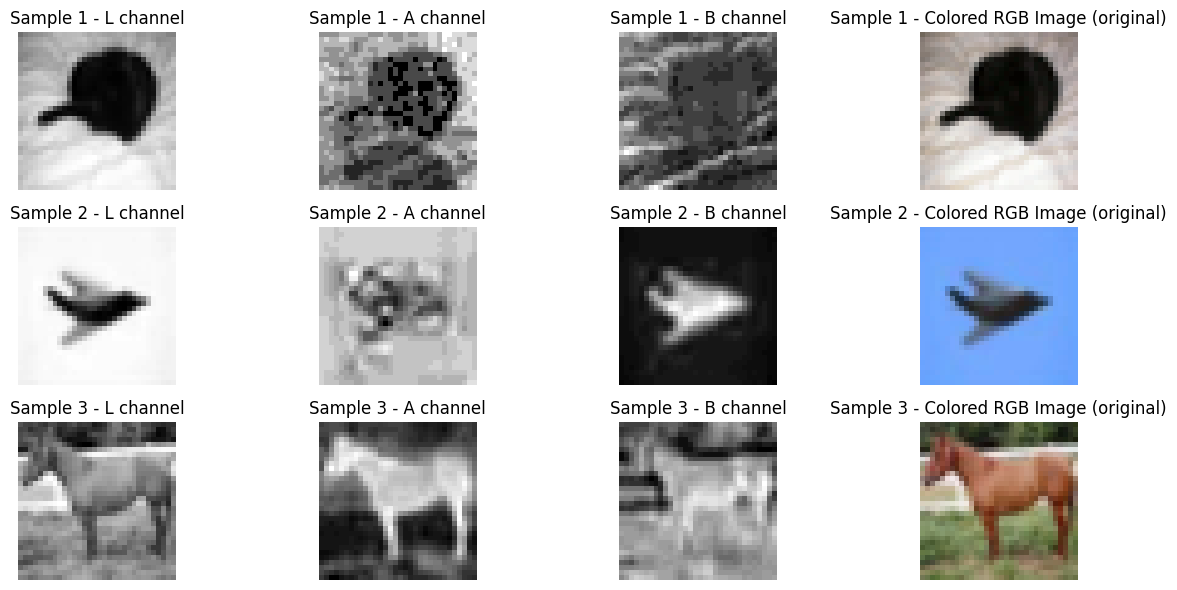

In [487]:
def plot_lab_and_rgb_images(l_batch, ab_batch, predicted_ab_batch=None, num_samples=3):
    fig, axs = plt.subplots(num_samples, 4, figsize=(13, num_samples * 2))

    for i in range(num_samples):
        l_img = l_batch[i]
        ab_img = ab_batch[i]

        # L channel
        axs[i, 0].imshow(l_img.squeeze(), cmap='gray', interpolation='none')
        axs[i, 0].set_title(f'Sample {i+1} - L channel')
        axs[i, 0].axis('off')

        # A channel
        axs[i, 1].imshow(ab_img[:, :, 0], cmap='gray', interpolation='none')
        axs[i, 1].set_title(f'Sample {i+1} - A channel')
        axs[i, 1].axis('off')

        # B channel
        axs[i, 2].imshow(ab_img[:, :, 1], cmap='gray', interpolation='none')
        axs[i, 2].set_title(f'Sample {i+1} - B channel')
        axs[i, 2].axis('off')

        # RGB Image
        if predicted_ab_batch is not None:
            rgb_img = lab_to_rgb(l_img, predicted_ab_batch[i])
            axs[i, 3].set_title(f'Sample {i+1} - Colored RGB Image (predicted)')

        else:
            rgb_img = lab_to_rgb(l_img, ab_img)
            axs[i, 3].set_title(f'Sample {i+1} - Colored RGB Image (original)')

        axs[i, 3].imshow(rgb_img, interpolation='none')
        axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

plot_lab_and_rgb_images(train_l_batch, train_ab_batch, num_samples=3)

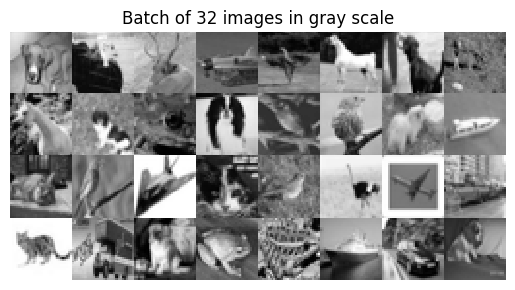

In [479]:
def plot_l_images(l_batch, imgs_in_row=8, title=None):
    imgs = l_batch
    imgs = imgs.reshape((len(l_batch)//imgs_in_row, imgs_in_row, *l_batch[0].shape))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    plt.figure()
    plt.axis('off')
    plt.title(title if title else f'Batch of {len(l_batch)} images in gray scale')
    plt.imshow(imgs, interpolation='none', cmap='gray')
    plt.show()

plot_l_images(val_l_batch)

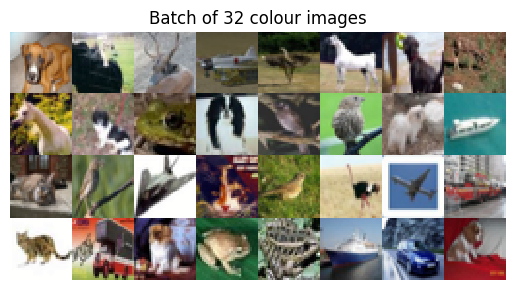

In [480]:
def plot_lab_images(l_batch, ab_batch, imgs_in_row=8, title=None):
    rgb_imgs = [lab_to_rgb(l, ab) for l, ab in zip(l_batch, ab_batch)]
    rgb_imgs = np.array(rgb_imgs)
    rgb_imgs = rgb_imgs.reshape((len(l_batch)//imgs_in_row, imgs_in_row, *l_batch[0].shape[:2], 3))
    imgs = np.vstack([np.hstack(i) for i in rgb_imgs])
    plt.figure()
    plt.axis('off')
    plt.title(f'Batch of {len(val_l_batch)} color images from CIFAR10')
    plt.title(title if title else f'Batch of {len(l_batch)} color images')
    plt.imshow(imgs, interpolation='none')
    plt.show()

plot_lab_images(val_l_batch, val_ab_batch)

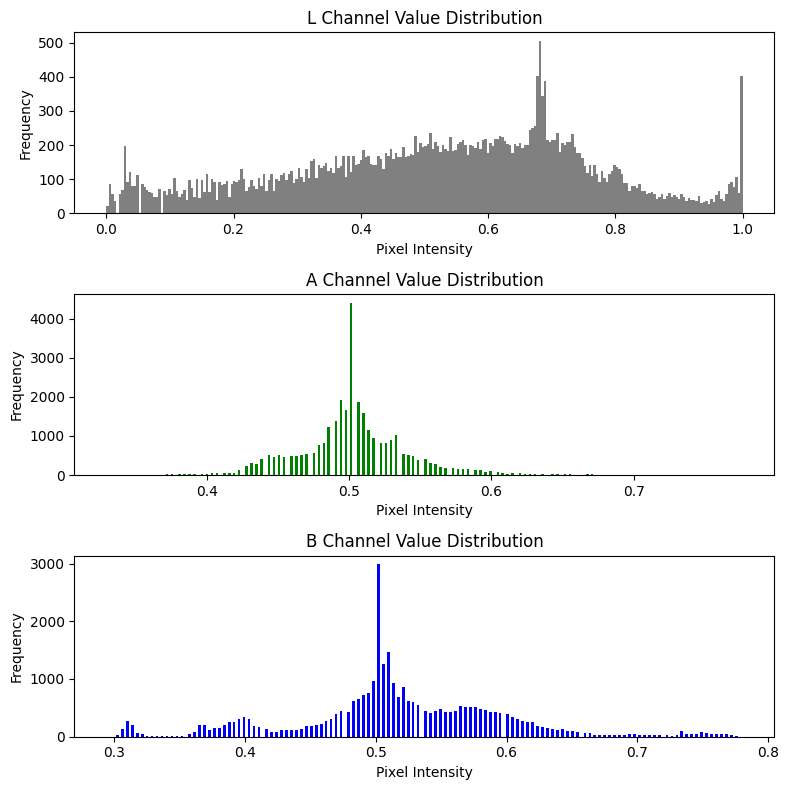

In [482]:
train_l_flat = train_l_batch.flatten()
train_a_flat = train_ab_batch[:, :, :, 0].flatten()
train_b_flat = train_ab_batch[:, :, :, 1].flatten()

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].hist(train_l_flat, bins=256, color='gray')
axs[0].set_title('L Channel Value Distribution')
axs[0].set_xlabel('Pixel Intensity')
axs[0].set_ylabel('Frequency')

axs[1].hist(train_a_flat, bins=256, color='green')
axs[1].set_title('A Channel Value Distribution')
axs[1].set_xlabel('Pixel Intensity')
axs[1].set_ylabel('Frequency')

axs[2].hist(train_b_flat, bins=256, color='blue')
axs[2].set_title('B Channel Value Distribution')
axs[2].set_xlabel('Pixel Intensity')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Metrics

Structural Similarity Index (SSIM): SSIM is a perception-based model that measures the similarity between two images. It considers image luminance, contrast, and structure. Higher SSIM values indicate better similarity between the colorized image and the ground truth.

In [493]:
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)
tf.keras.metrics.ssim = ssim

# Model Architectures

## Trainer

In [398]:
class ModelTrainer:
    def __init__(self, model, train_generator, val_generator, train_steps, val_steps, epochs=30, verbose=1, save_best_only=True, save_path=None):
        self.model = model
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.train_steps = train_steps
        self.val_steps = val_steps
        self.epochs = epochs
        self.verbose = verbose
        self.history = None
        self.save_best_only = save_best_only
        self.save_path = save_path
        
        lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                           cooldown=0,
                           patience=5,
                           verbose=self.verbose,
                           min_lr=0.5e-6)
        self.callbacks = [lr_reducer]

        if self.save_path:
            checkpoint_callback = ModelCheckpoint(filepath=self.save_path,
                                                  monitor='val_loss',
                                                  save_best_only=self.save_best_only,
                                                  verbose=self.verbose,
                                                  mode='min',
                                                  save_weights_only=False)
            self.callbacks.append(checkpoint_callback)
            

    def compile_model(self, optimizer='adam', loss='mean_squared_error', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train(self):
        gpu_devices = tf.config.list_physical_devices('GPU')
        if gpu_devices:
            print("Training on GPU.")
            with tf.device('/GPU:0'):
                self._train_on_device()
        else:
            print("No GPU available. Training on CPU.")
            self._train_on_device('/CPU:0')


    def _train_on_device(self, device='/GPU:0'):
        with tf.device(device):
            self.history = self.model.fit(self.train_generator,
                                          steps_per_epoch=self.train_steps,
                                          validation_data=self.val_generator,
                                          validation_steps=self.val_steps,
                                          epochs=self.epochs,
                                          callbacks=self.callbacks,
                                          verbose=self.verbose
                                          )

    def plot_history(self):
        if self.history is None:
            print("No training history available.")
            return
        history = self.history.history

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

## Evaluator

In [538]:
class ModelEvaluator:
    def __init__(self, model, val_generator, val_steps):
        self.model = model
        self.val_generator = val_generator
        self.val_steps = val_steps

    def evaluate(self):
        evaluation_metrics = self.model.evaluate(self.val_generator, steps=self.val_steps)
        evaluation_results = {}

        loss = evaluation_metrics[0]
        print(f'Validation Loss: {loss:.4}')
        evaluation_results['Loss'] = loss

        for i, metric_name in enumerate(self.model.metrics_names[1:]):
            metric_value = evaluation_metrics[i + 1]
            print(f'Validation {metric_name}: {metric_value:.4}')
            evaluation_results[metric_name] = metric_value
        return evaluation_results

## Pipeline

In [307]:
# class ColorizationPipeline(Pipeline):
#     def __init__(self, model, train_generator, val_generator, train_steps, val_steps, n_epochs=30):
#         self.is_fit = False 
        
#         self.model = model
#         self.train_generator = train_generator
#         self.val_generator = val_generator
#         self.train_steps = train_steps
#         self.val_steps = val_steps
#         self.n_epochs = n_epochs
#         self.trainer = None
#         self.history = None

#     def fit(self):
#         self.is_fit = True
        
#         self.trainer = ModelTrainer(
#             self.model, 
#             self.train_generator, 
#             self.val_generator, 
#             self.train_steps, 
#             self.val_steps, 
#             epochs=self.n_epochs, 
#             verbose=1
#         )
#         self.trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
#         self.history = self.trainer.train()
#         self.trainer.plot_history()

#     def evaluate(self):
#         if not self.is_fit:
#             self.fit(X)
            
#         evaluator = ModelEvaluator(self.model, self.val_generator, self.val_steps)
#         evaluator.evaluate()

#         val_l_batch, val_ab_batch = next(self.val_generator)
#         predicted_ab = self.model.predict(val_l_batch)

#         plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
#         print()
#         plot_lab_and_rgb_images(val_l_batch, predicted_ab, num_samples=3)

#     def predict(self, batches_num=1, imgs_in_row=8):
#         if not self.is_fit:
#             self.fit(X)
            
#         val_l_batches, val_ab_batches = self.take_x_batches(self.val_generator, batches_num)
#         predicted_ab = self.model.predict(val_l_batches)
#         plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=imgs_in_row, title=f'Batch of {len(l_batch)} original color images')
#         plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=imgs_in_row, title=f'Batch of {len(l_batch)} predicted color images')

#     def score(self):
#         try:
#             val_l_batch, val_ab_batch = next(self.val_generator)
#             predicted_ab = self.model.predict(val_l_batch)

#             ssim_score = ssim(val_ab_batch, predicted_ab)
#             print(f"SSIM Score: {ssim_score}")

#             mse_score = np.mean((val_ab_batch - predicted_ab) ** 2)
#             print(f"MSE Score: {mse_score}")

#             plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3, title="Original Images")
#             plot_lab_and_rgb_images(val_l_batch, predicted_ab, num_samples=3, title="Predicted Images")

#         except StopIteration:
#             print("Validation generator is exhausted. Cannot compute scores.")

#         except Exception as e:
#             print(f"Error occurred during scoring: {str(e)}")


## Encoder-decoder models

In [543]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gc.collect()

Num GPUs Available:  1


128275

### Simple Encoder-Decoder

In [495]:
def build_simple_model(input_shape=(32, 32, 1)):
    model = Sequential()

    # Encoder
    model.add(InputLayer(input_shape=input_shape))
    model.add(Conv2D(12, (5, 5), strides=1, padding='valid', activation='relu'))
    model.add(Conv2D(24, (5, 5), strides=1, padding='valid', activation='relu'))
    # Decoder
    model.add(Conv2DTranspose(24, (5, 5), strides=1, padding='valid', activation='relu'))
    model.add(Conv2DTranspose(2, (5, 5), strides=1, padding='valid', activation='relu'))

    model.build((None, *input_shape))
    return model

simple_model = build_simple_model()
simple_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_770 (Conv2D)         (None, 28, 28, 12)        312       
                                                                 
 conv2d_771 (Conv2D)         (None, 24, 24, 24)        7224      
                                                                 
 conv2d_transpose_191 (Conv2  (None, 28, 28, 24)       14424     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_192 (Conv2  (None, 32, 32, 2)        1202      
 DTranspose)                                                     
                                                                 
Total params: 23,162
Trainable params: 23,162
Non-trainable params: 0
_________________________________________________________________


Training on GPU.
Epoch 1/30
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0056 - accuracy: 0.5753 - ssim: 0.6985 - val_loss: 0.0027 - val_accuracy: 0.5852 - val_ssim: 0.7611 - lr: 0.0010
Epoch 2/30
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0028 - accuracy: 0.5883 - ssim: 0.7620 - val_loss: 0.0030 - val_accuracy: 0.5852 - val_ssim: 0.7657 - lr: 0.0010
Epoch 3/30
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0028 - accuracy: 0.5932 - ssim: 0.7662 - val_loss: 0.0028 - val_accuracy: 0.5813 - val_ssim: 0.7712 - lr: 0.0010
Epoch 4/30
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0027 - accuracy: 0.5972 - ssim: 0.7677 - val_loss: 0.0028 - val_accuracy: 0.5775 - val_ssim: 0.7691 - lr: 0.0010
Epoch 5/30
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0027 - accuracy: 0.5997 - ssim: 0.7701 - val_loss: 0.0026 - val_accuracy: 0.5970 - val_ssim: 0.7734 - lr: 0.0010
Epoch 6/30
1500/1500 [=====

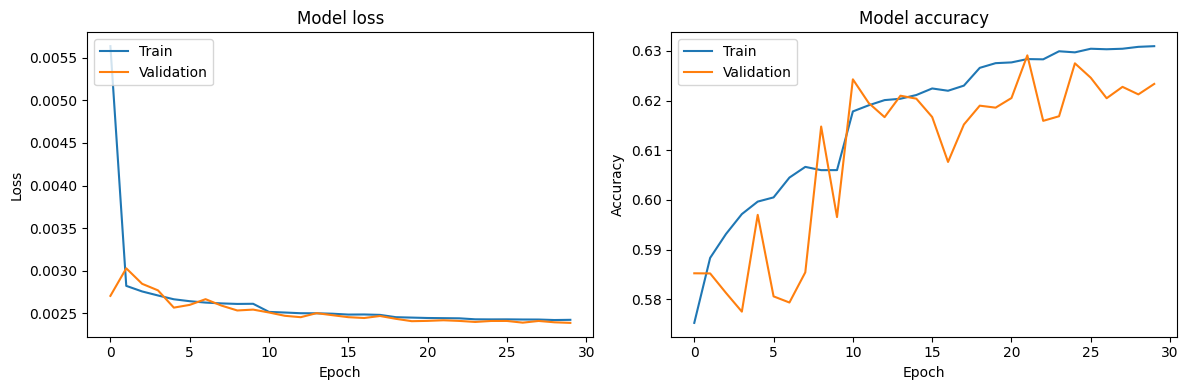

In [496]:
trainer = ModelTrainer(simple_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

In [539]:
evaluator = ModelEvaluator(simple_model, val_generator, val_steps)
evaluator.evaluate()

187/187 [==============================] - 1s 4ms/step - loss: 0.0024 - accuracy: 0.6283 - ssim: 0.7748
Validation Loss: 0.002386
Validation accuracy: 0.6283
Validation ssim: 0.7748


{'Loss': 0.0023859571665525436,
 'accuracy': 0.6282618641853333,
 'ssim': 0.774823009967804}

In [540]:
test_evaluator = ModelEvaluator(simple_model, test_generator, test_steps)
test_evaluator.evaluate()

187/187 [==============================] - 1s 3ms/step - loss: 0.0024 - accuracy: 0.6347 - ssim: 0.7726
Validation Loss: 0.002448
Validation accuracy: 0.6347
Validation ssim: 0.7726


{'Loss': 0.0024481555446982384,
 'accuracy': 0.6347162127494812,
 'ssim': 0.7725898027420044}

1/1 [==============================] - 0s 16ms/step


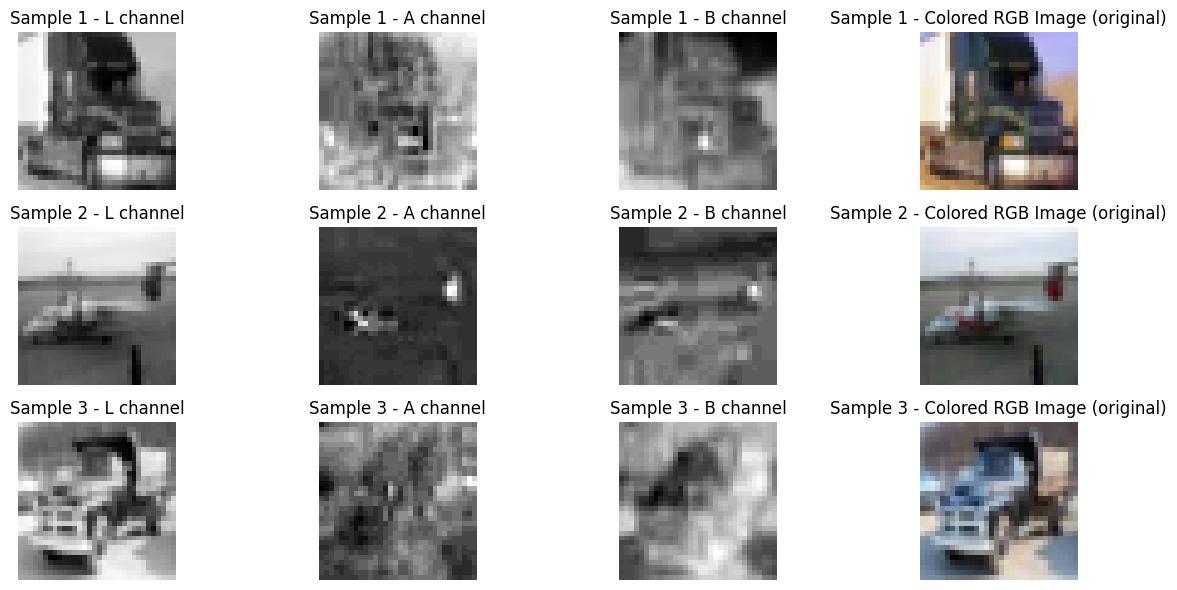

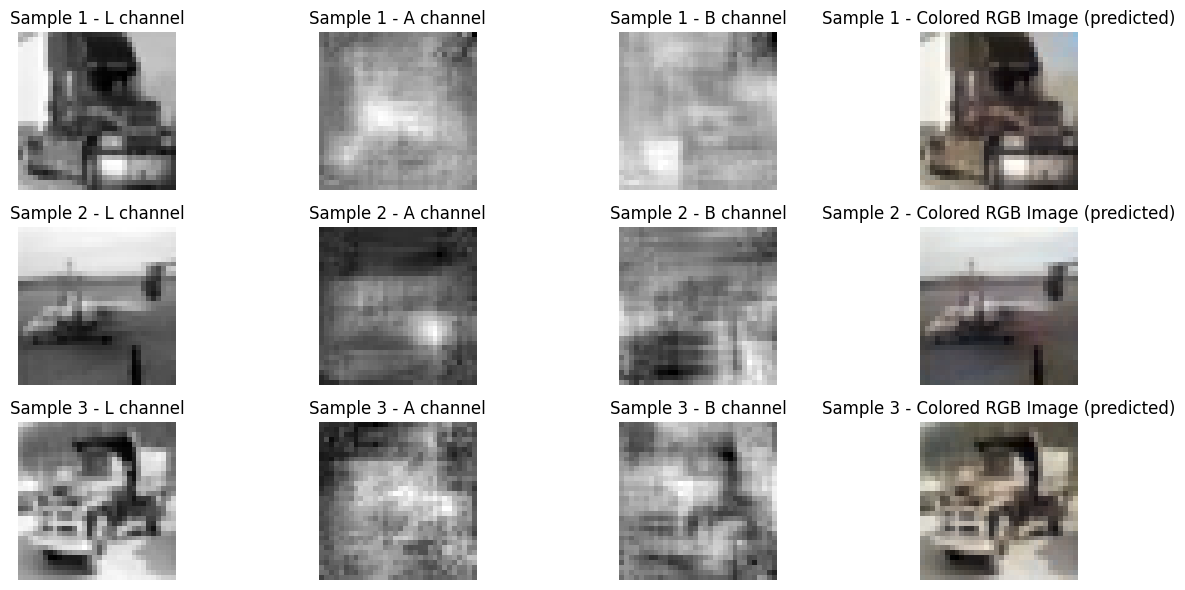

In [541]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = simple_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = simple_model.predict(val_l_batches)
title = "Simple Encoder-Decoder\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

### U-Net with BatchNormalization and MaxPooling2D

In [ ]:
def build_unet_model(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)
    x = inputs

    # Encoder
    layer_filters=[64, 128, 256]
    for filters in layer_filters:
        x = Conv2D(filters=filters,
                   kernel_size=3,
                   padding='same',
                   strides=1,
                   activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Decoder
    for filters in layer_filters[::-1]:        
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(filters=filters,
           kernel_size=3,
           padding='same',
           strides=1,
           activation='relu')(x)
        x = BatchNormalization()(x)
    
    outputs = Conv2D(2, (1, 1), activation='sigmoid', padding='same')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

unet_model = build_unet_model(input_shape=(*img_size, 1))
unet_model.summary()
tf.keras.utils.plot_model(unet_model, show_shapes=True, dpi=64)

Training on GPU.
Epoch 1/30
1500/1500 [==============================] - 48s 32ms/step - loss: 0.0029 - accuracy: 0.6094 - ssim: 0.7509 - val_loss: 0.0026 - val_accuracy: 0.5938 - val_ssim: 0.7728 - lr: 0.0010
Epoch 2/30
1500/1500 [==============================] - 51s 34ms/step - loss: 0.0024 - accuracy: 0.6360 - ssim: 0.7748 - val_loss: 0.0034 - val_accuracy: 0.4518 - val_ssim: 0.7611 - lr: 0.0010
Epoch 3/30
1500/1500 [==============================] - 48s 32ms/step - loss: 0.0023 - accuracy: 0.6443 - ssim: 0.7776 - val_loss: 0.0046 - val_accuracy: 0.5553 - val_ssim: 0.7530 - lr: 0.0010
Epoch 4/30
1500/1500 [==============================] - 49s 33ms/step - loss: 0.0023 - accuracy: 0.6487 - ssim: 0.7788 - val_loss: 0.0024 - val_accuracy: 0.6095 - val_ssim: 0.7803 - lr: 0.0010
Epoch 5/30
1500/1500 [==============================] - 49s 32ms/step - loss: 0.0023 - accuracy: 0.6547 - ssim: 0.7804 - val_loss: 0.0026 - val_accuracy: 0.6334 - val_ssim: 0.7709 - lr: 0.0010
Epoch 6/30
1500/15

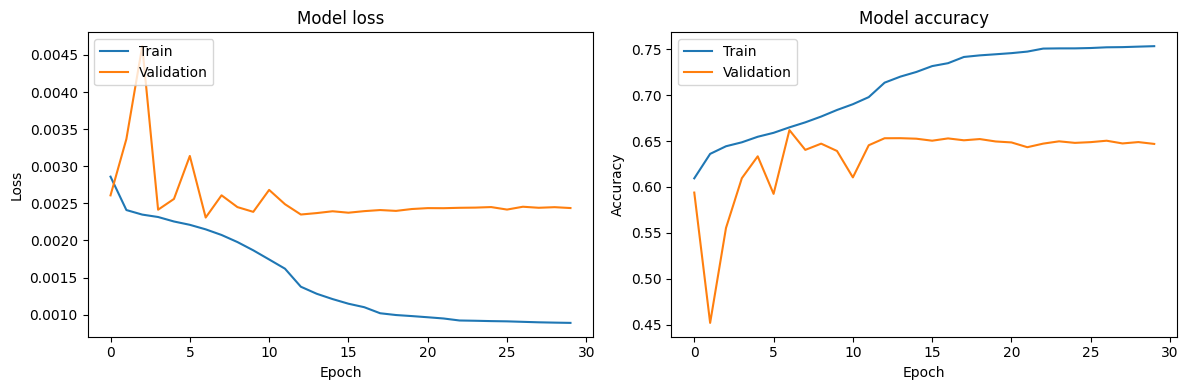

In [545]:
trainer = ModelTrainer(unet_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

In [546]:
evaluator = ModelEvaluator(unet_model, val_generator, val_steps)
evaluator.evaluate()

187/187 [==============================] - 2s 12ms/step - loss: 0.0024 - accuracy: 0.6476 - ssim: 0.7669
Validation Loss: 0.002446
Validation accuracy: 0.6476
Validation ssim: 0.7669


{'Loss': 0.002445613732561469,
 'accuracy': 0.647564709186554,
 'ssim': 0.7668983936309814}

In [549]:
evaluator = ModelEvaluator(unet_model, test_generator, test_steps)
evaluator.evaluate()

187/187 [==============================] - 2s 12ms/step - loss: 0.0025 - accuracy: 0.6485 - ssim: 0.7640
Validation Loss: 0.002503
Validation accuracy: 0.6485
Validation ssim: 0.764


{'Loss': 0.002503341529518366,
 'accuracy': 0.6485329270362854,
 'ssim': 0.7639744877815247}

1/1 [==============================] - 0s 147ms/step


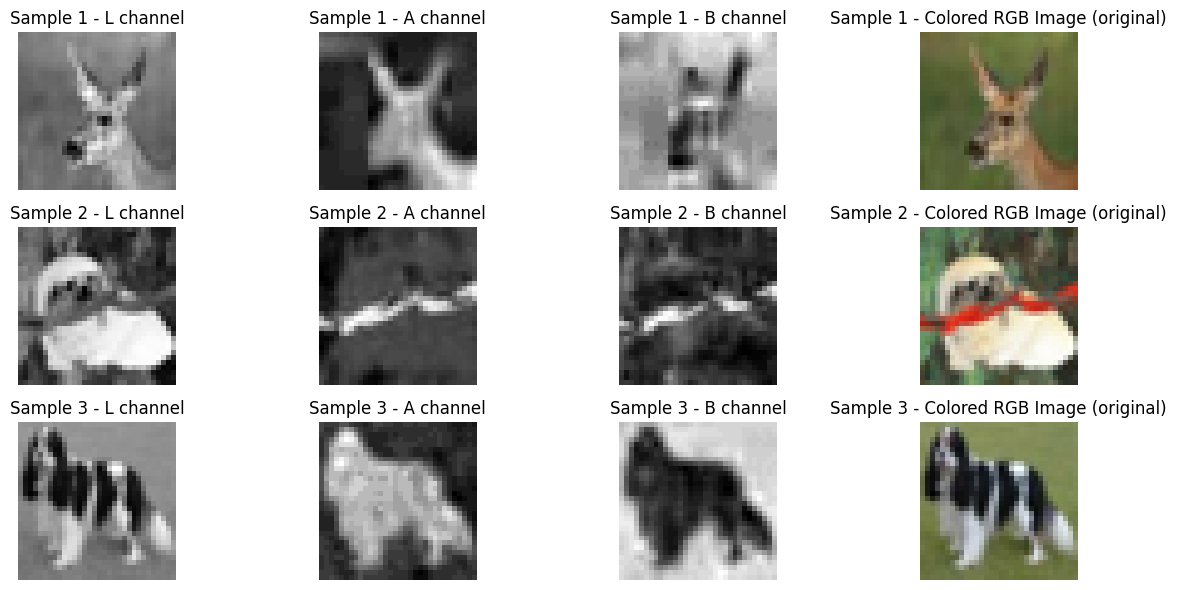

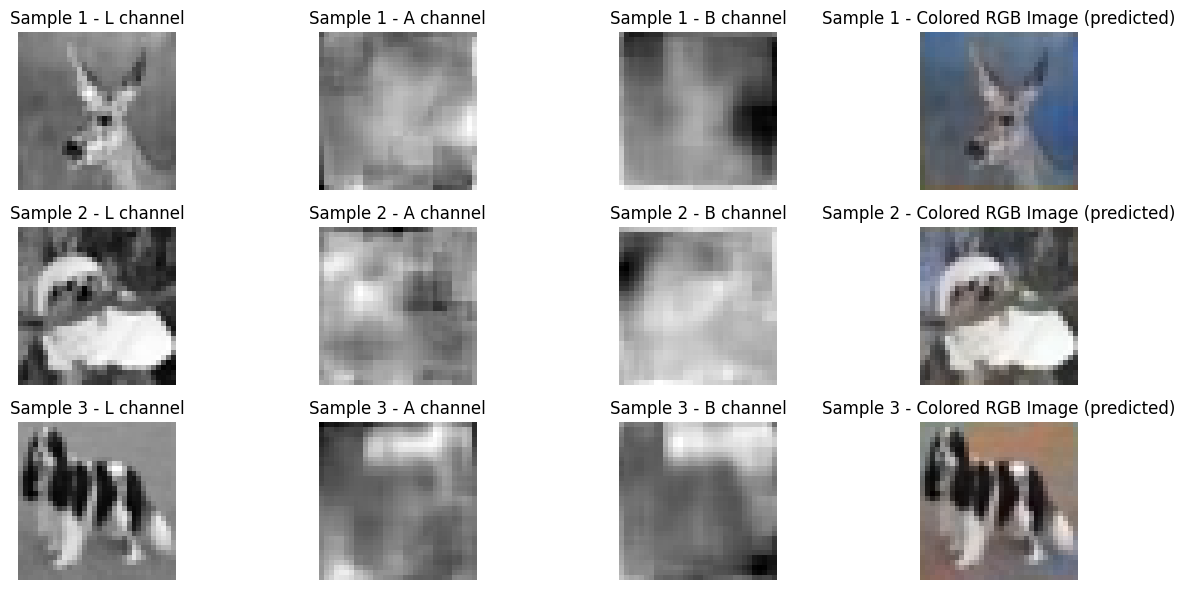

In [547]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = unet_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = unet_model.predict(val_l_batches)
title = "U-Net with BatchNormalization and MaxPooling2D\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

### U-Net with BatchNormalization and AveragePooling2D

In [ ]:
def build_unet_model_2(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)
    x = inputs

    # Encoder
    layer_filters=[64, 128, 256]
    for filters in layer_filters:
        x = Conv2D(filters=filters,
                   kernel_size=3,
                   padding='same',
                   strides=1,
                   activation='relu')(x)
        x = BatchNormalization()(x)
        x = AveragePooling2D((2, 2))(x)

    # Bottleneck
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Decoder
    for filters in layer_filters[::-1]:        
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(filters=filters,
           kernel_size=3,
           padding='same',
           strides=1,
           activation='relu')(x)
        x = BatchNormalization()(x)
    
    outputs = Conv2D(2, (1, 1), activation='sigmoid', padding='same')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

unet_model_2 = build_unet_model_2(input_shape=(*img_size, 1))
unet_model_2.summary()
tf.keras.utils.plot_model(unet_model_2, show_shapes=True, dpi=64)

Training on GPU.
Epoch 1/30
1500/1500 [==============================] - 51s 33ms/step - loss: 0.0029 - accuracy: 0.5998 - ssim: 0.7543 - val_loss: 0.0037 - val_accuracy: 0.5358 - val_ssim: 0.7594 - lr: 0.0010
Epoch 2/30
1500/1500 [==============================] - 50s 33ms/step - loss: 0.0025 - accuracy: 0.6254 - ssim: 0.7730 - val_loss: 0.0025 - val_accuracy: 0.6247 - val_ssim: 0.7752 - lr: 0.0010
Epoch 3/30
1500/1500 [==============================] - 52s 35ms/step - loss: 0.0024 - accuracy: 0.6381 - ssim: 0.7761 - val_loss: 0.0024 - val_accuracy: 0.6343 - val_ssim: 0.7774 - lr: 0.0010
Epoch 4/30
1500/1500 [==============================] - 50s 33ms/step - loss: 0.0023 - accuracy: 0.6444 - ssim: 0.7780 - val_loss: 0.0029 - val_accuracy: 0.6071 - val_ssim: 0.7671 - lr: 0.0010
Epoch 5/30
1500/1500 [==============================] - 53s 35ms/step - loss: 0.0023 - accuracy: 0.6496 - ssim: 0.7791 - val_loss: 0.0024 - val_accuracy: 0.6415 - val_ssim: 0.7766 - lr: 0.0010
Epoch 6/30
1500/15

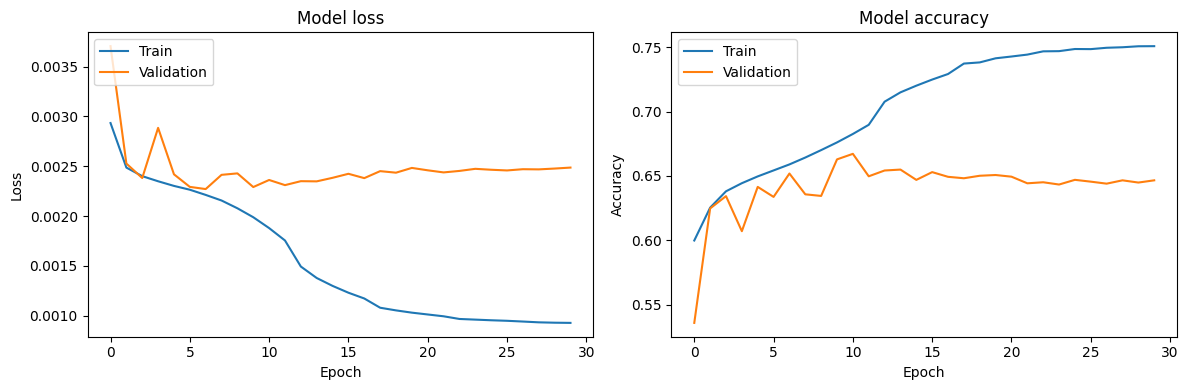

In [551]:
trainer = ModelTrainer(unet_model_2, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

In [552]:
evaluator = ModelEvaluator(unet_model_2, val_generator, val_steps)
evaluator.evaluate()

187/187 [==============================] - 2s 12ms/step - loss: 0.0025 - accuracy: 0.6451 - ssim: 0.7647
Validation Loss: 0.002481
Validation accuracy: 0.6451
Validation ssim: 0.7647


{'Loss': 0.0024808559101074934,
 'accuracy': 0.6450862884521484,
 'ssim': 0.7647061347961426}

In [553]:
evaluator = ModelEvaluator(unet_model_2, test_generator, test_steps)
evaluator.evaluate()

187/187 [==============================] - 2s 12ms/step - loss: 0.0025 - accuracy: 0.6498 - ssim: 0.7625
Validation Loss: 0.002483
Validation accuracy: 0.6498
Validation ssim: 0.7625


{'Loss': 0.002483054995536804,
 'accuracy': 0.6498095393180847,
 'ssim': 0.7625201344490051}

1/1 [==============================] - 0s 142ms/step


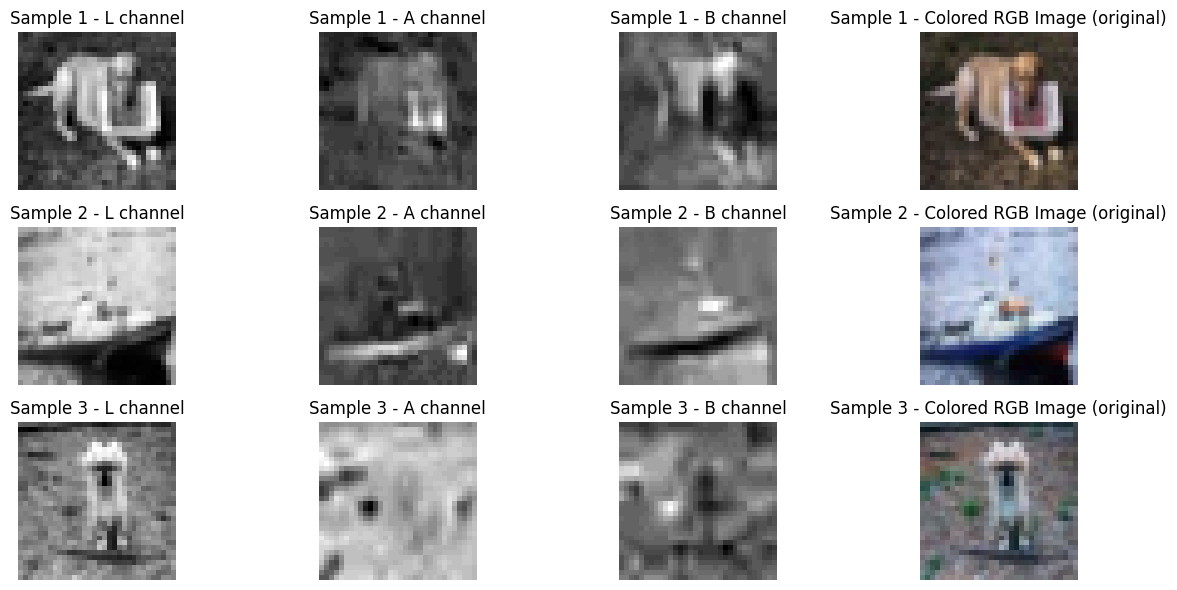

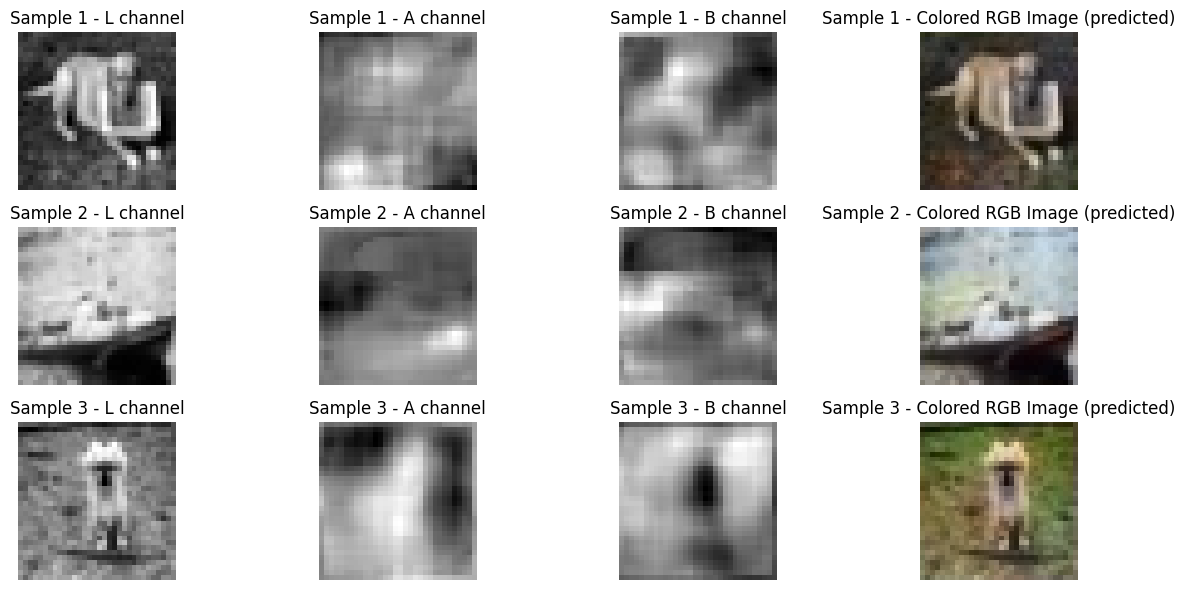

In [554]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = unet_model_2.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = unet_model_2.predict(val_l_batches)
title = "U-Net with BatchNormalization and AveragePooling2D\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

### U-Net with Skip Connections

In [ ]:
def unet_model_3(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)
    
    # Contracting path
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bottom
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)
    
    # Expansive path
    u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u1 = Concatenate()([u1, c4])
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u1)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)
    
    u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u2 = Concatenate()([u2, c3])
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u2)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)
    
    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u3 = Concatenate()([u3, c2])
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u3)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)
    
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u4 = Concatenate()([u4, c1])
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u4)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)
    
    # Output layer
    outputs = Conv2D(2, (1, 1), activation='sigmoid')(c9) # softmax
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

unet_model_3 = unet_model_3()

unet_model_3.summary()
tf.keras.utils.plot_model(unet_model_3, show_shapes=True, dpi=64)

In [ ]:
trainer = ModelTrainer(unet_model_3, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

Training on GPU.
Epoch 1/30
1500/1500 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.6020 - ssim: 0.7787
Epoch 1: val_loss improved from inf to 0.00246, saving model to models\unet_model_3_model_checkpoint.h5
1500/1500 [==============================] - 223s 148ms/step - loss: 0.0026 - accuracy: 0.6020 - ssim: 0.7787 - val_loss: 0.0025 - val_accuracy: 0.6203 - val_ssim: 0.7809 - lr: 0.0010
Epoch 2/30
1500/1500 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.6353 - ssim: 0.7813
Epoch 2: val_loss improved from 0.00246 to 0.00245, saving model to models\unet_model_3_model_checkpoint.h5
1500/1500 [==============================] - 215s 143ms/step - loss: 0.0024 - accuracy: 0.6353 - ssim: 0.7813 - val_loss: 0.0025 - val_accuracy: 0.6449 - val_ssim: 0.7824 - lr: 0.0010
Epoch 3/30
1500/1500 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.6431 - ssim: 0.7832
Epoch 3: val_loss improved from 0.00245 to 0.00228, saving model

In [ ]:
evaluator = ModelEvaluator(unet_model_3, val_generator, val_steps)
evaluator.evaluate()

In [ ]:
evaluator = ModelEvaluator(unet_model_3, test_generator, test_steps)
evaluator.evaluate()

In [ ]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = unet_model_3.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = unet_model_3.predict(val_l_batches)
title = "U-Net with Skip Connections\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

## AEs

#### Autoencoder with latent dimension 64

In [ ]:
def build_autoencoder_64(input_shape, latent_dim=64):
    # Encoder
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = encoder_input

    layer_filters=[64, 128, 256, 512, 1024]
    for filters in layer_filters:
        x = Conv2D(filters=filters,
                   kernel_size=3,
                   padding='same',
                   strides=2,
                   activation='relu')(x)

    shape = K.int_shape(x)
    x = Flatten()(x)
    latent_vector = Dense(latent_dim, name='latent_vector')(x)

    encoder = Model(encoder_input, latent_vector, name='encoder')
    encoder.summary()

    # Decoder
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(shape[1] * shape[2] * shape[3])(decoder_input)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=3,
                            padding='same',
                            strides=2,
                           activation='relu')(x)

    decoder_output = Conv2DTranspose(filters=2,
                              kernel_size=3,
                              padding='same',
                              activation='sigmoid',
                              name='decoder_output')(x)

    decoder = Model(decoder_input, decoder_output, name='decoder')
    decoder.summary()

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='autoencoder')
    return autoencoder

ae_64_model = build_autoencoder_64(input_shape=(32, 32, 1))
ae_64_model.summary()

In [ ]:
trainer = ModelTrainer(ae_64_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

In [ ]:
evaluator = ModelEvaluator(ae_64_model, val_generator, val_steps)
evaluator.evaluate()

In [ ]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = ae_64_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = ae_64_model.predict(val_l_batches)
title = "AutoencoderLatent64\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

#### Autoencoder with latent dimension 256

In [ ]:
def build_autoencoder_256(input_shape, latent_dim=256):
    
    # Encoder
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = encoder_input

    layer_filters=[64, 128, 256]
    for filters in layer_filters:
        x = Conv2D(filters=filters,
                   kernel_size=3,
                   padding='same',
                   strides=2,
                   activation='relu')(x)

    shape = K.int_shape(x)
    x = Flatten()(x)
    latent_vector = Dense(latent_dim, name='latent_vector')(x)

    encoder = Model(encoder_input, latent_vector, name='encoder')
    encoder.summary()

    # Decoder
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(shape[1] * shape[2] * shape[3])(decoder_input)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=3,
                            padding='same',
                            strides=2,
                           activation='relu')(x)

    decoder_output = Conv2DTranspose(filters=2,
                              kernel_size=3,
                              padding='same',
                              activation='sigmoid',
                              name='decoder_output')(x)

    decoder = Model(decoder_input, decoder_output, name='decoder')
    decoder.summary()

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='autoencoder')
    return autoencoder

ae_256_model = build_autoencoder_256(input_shape=(32, 32, 1))
ae_256_model.summary()

In [ ]:
trainer = ModelTrainer(ae_256_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

In [ ]:
evaluator = ModelEvaluator(ae_256_model, val_generator, val_steps)
evaluator.evaluate()

In [ ]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = ae_256_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = ae_256_model.predict(val_l_batches)
title = "AutoencoderLatent256\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

#### Autoencoder with latent dimension 256 and BatchNormalization

In [ ]:
def build_autoencoder_256_bn(input_shape=(32, 32, 1), latent_dim=256):
    # Encoder
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = encoder_input

    layer_filters=[64, 128, 256]
    for filters in layer_filters:
        x = Conv2D(filters=filters,
                   kernel_size=3,
                   padding='same',
                   strides=2,
                   activation='relu')(x)
        x = BatchNormalization()(x)

    shape = K.int_shape(x)
    x = Flatten()(x)
    latent_vector = Dense(latent_dim, name='latent_vector')(x)

    encoder = Model(encoder_input, latent_vector, name='encoder')
    encoder.summary()

    # Decoder
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(shape[1] * shape[2] * shape[3])(decoder_input)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=3,
                            padding='same',
                            strides=2,
                           activation='relu')(x)
        x = BatchNormalization()(x)

    decoder_output = Conv2DTranspose(filters=2,
                              kernel_size=3,
                              padding='same',
                              activation='sigmoid',
                              name='decoder_output')(x)

    decoder = Model(decoder_input, decoder_output, name='decoder')
    decoder.summary()

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='autoencoder')
    return autoencoder

ae_256_bn_model = build_autoencoder_256_bn()
ae_256_bn_model.summary()

In [ ]:
trainer = ModelTrainer(ae_256_bn_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

In [ ]:
evaluator = ModelEvaluator(ae_256_bn_model, val_generator, val_steps)
evaluator.evaluate()

In [ ]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = ae_256_bn_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = ae_256_bn_model.predict(val_l_batches)
title = "AutoencoderLatent256BN\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

#### Autoencoder with VGG16 Backbone

In [ ]:
def build_vgg_autoencoder(input_shape=(32, 32, 1)):
    latent_dim=256
    
    encoder_input = Input(shape=input_shape, name='l_input')
    rgb_input = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(encoder_input)  # add a dummy channelsAB

    # VGG16 Encoder
    vgg_encoder = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    for layer in vgg_encoder.layers:
        layer.trainable = False
        
    vgg_output = vgg_encoder(rgb_input)
    # x = Conv2D(filters=64,
    #                kernel_size=3,
    #                padding='same',
    #                strides=2,
    #                activation='relu')(vgg_output)

    # shape = K.int_shape(vgg_output)
    print(shape)
    vgg_output = Flatten()(vgg_output)
    latent_vector = Dense(latent_dim, name='latent_vector')(vgg_output)
    
    encoder = Model(encoder_input, latent_vector, name='vgg_encoder')
    encoder.summary()

    # Decoder
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(shape[1] * shape[2] * shape[3])(decoder_input)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    layer_filters=[64, 128, 256]
    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=3,
                            padding='same',
                            strides=2,
                           activation='relu')(x)

    decoder_output = Conv2DTranspose(filters=2,
                              kernel_size=3,
                              padding='same',
                              activation='sigmoid',
                              name='decoder_output')(x)

    decoder = Model(decoder_input, decoder_output, name='decoder')
    decoder.summary()

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='vgg-autoencoder')
    return autoencoder

ae_vgg_model = build_vgg_autoencoder(input_shape=(32, 32, 1))
ae_vgg_model.summary()

In [ ]:
trainer = ModelTrainer(ae_vgg_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = trainer.train()
trainer.plot_history()

In [ ]:
evaluator = ModelEvaluator(ae_vgg_model, val_generator, val_steps)
evaluator.evaluate()

In [ ]:
evaluator = ModelEvaluator(ae_vgg_model, test_generator, test_steps)
evaluator.evaluate()

In [ ]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = ae_vgg_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = ae_vgg_model.predict(val_l_batches)
title = "Autoencoder with VGG16 Backbone\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

## RNN (LSTM 128)

In [ ]:
def build_rnn_model(input_shape=(32, 32, 1), units=128):
    inputs = Input(shape=input_shape)
    
    reshaped_inputs = Reshape((-1, np.prod(input_shape)))(inputs)
    lstm_layer = LSTM(units, return_sequences=True)(reshaped_inputs)
    dense_output = Dense(np.prod(input_shape) * 2, activation='sigmoid')(lstm_layer)
    outputs = Reshape((32, 32, 2))(dense_output)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

rnn128_model = build_rnn_model(units=128)
rnn128_model.summary()

In [ ]:
tf.keras.utils.plot_model(rnn128_model, show_shapes=True, dpi=64)

In [ ]:
trainer = ModelTrainer(rnn128_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

In [ ]:
evaluator = ModelEvaluator(rnn128_model, val_generator, val_steps)
evaluator.evaluate()

In [ ]:
evaluator = ModelEvaluator(rnn128_model, test_generator, test_steps)
evaluator.evaluate()

In [ ]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = rnn128_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = rnn128_model.predict(val_l_batches)
title = "RNN (LSTM 128)\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

## RNN (LSTM 256)

In [ ]:
rnn256_model = build_rnn_model(units=256)
rnn256_model.summary()

In [ ]:
trainer = ModelTrainer(rnn256_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

In [ ]:
evaluator = ModelEvaluator(rnn256_model, val_generator, val_steps)
evaluator.evaluate()

In [ ]:
evaluator = ModelEvaluator(rnn256_model, test_generator, test_steps)
evaluator.evaluate()

In [ ]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = rnn256_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = rnn256_model.predict(val_l_batches)
title = "RNN (LSTM 256)\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

## RNN (LSTM 512)

In [ ]:
rnn512_model = build_rnn_model(units=512)
rnn512_model.summary()

In [ ]:
trainer = ModelTrainer(rnn512_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

In [ ]:
evaluator = ModelEvaluator(rnn512_model, val_generator, val_steps)
evaluator.evaluate()

In [ ]:
evaluator = ModelEvaluator(rnn512_model, test_generator, test_steps)
evaluator.evaluate()

In [ ]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = rnn512_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = rnn512_model.predict(val_l_batches)
title = "RNN (LSTM 512)\n" + f'Batch of {len(val_l_batches)} '
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title='original images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')

# Not completed models

## VAE MLP

In [ ]:
# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# def build_vae_encoder(input_shape, latent_dim):
#     inputs = Input(shape=input_shape, name='encoder_input')
#     x = Flatten()(inputs)
#     x = Dense(512, activation='relu')(x)
#     x = Dense(256, activation='relu')(x)
#     z_mean = Dense(latent_dim, name='z_mean')(x)
#     z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
#     return Model(inputs, [z_mean, z_log_var], name='encoder')

# encoder = build_vae_encoder(input_shape=(32, 32, 1), latent_dim=16)
# encoder.summary()

In [ ]:
# def build_vae_decoder(latent_dim, output_shape):
#     latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    
#     dense_units = np.prod(output_shape)
    
#     x = Dense(256, activation='relu')(latent_inputs)
#     x = Dense(512, activation='relu')(x)
#     x = Dense(dense_units, activation='sigmoid')(x)
#     outputs = Reshape(output_shape)(x)
    
#     return Model(latent_inputs, outputs, name='decoder')

    
# decoder = build_vae_decoder(latent_dim=16, output_shape=(32, 32, 2))
# decoder.summary()

In [ ]:
# def build_vae(input_shape, latent_dim):
#     encoder = build_vae_encoder(input_shape, latent_dim)
#     decoder = build_vae_decoder(latent_dim, (input_shape[0], input_shape[1], 2))
    
#     inputs = Input(shape=input_shape, name='encoder_input')
#     z_mean, z_log_var = encoder(inputs)
#     z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
#     outputs = decoder(z)
    
#     vae = Model(inputs, outputs, name='vae')
    
#     # Compute VAE loss
#     reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
#     reconstruction_loss *= input_shape[0] * input_shape[1]
#     kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
#     kl_loss = K.sum(kl_loss, axis=-1)
#     kl_loss *= -0.5
#     vae_loss = K.mean(reconstruction_loss + kl_loss)
    
#     vae.add_loss(vae_loss)
    
#     return encoder, decoder, vae

# encoder, decoder, vae_model = build_vae(input_shape=(32, 32, 1), latent_dim=16)
# tf.keras.utils.plot_model(vae_model, show_shapes=True, dpi=64)
# vae_model.summary()

In [ ]:
# from tensorflow.keras import layers, models, backend as K

# # Encoder: MLP-based
# def build_vae_encoder(input_shape, latent_dim):
#     inputs = layers.Input(shape=input_shape, name='encoder_input')
#     x = layers.Flatten()(inputs)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dense(256, activation='relu')(x)
#     z_mean = layers.Dense(latent_dim, name='z_mean')(x)
#     z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
#     return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# # Decoder: MLP-based
# def build_vae_decoder(latent_dim, output_shape):
#     latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
#     dense_units = np.prod(output_shape)
#     x = layers.Dense(256, activation='relu')(latent_inputs)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dense(dense_units, activation='sigmoid')(x)
#     outputs = layers.Reshape(output_shape)(x)
#     return models.Model(latent_inputs, outputs, name='decoder')

# # VAE model
# def build_vae(input_shape, latent_dim):
#     encoder = build_vae_encoder(input_shape, latent_dim)
#     decoder = build_vae_decoder(latent_dim, (input_shape[0], input_shape[1], 2))
    
#     inputs = layers.Input(shape=input_shape, name='encoder_input')
#     z_mean, z_log_var = encoder(inputs)
#     z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
#     outputs = decoder(z)
    
#     vae = models.Model(inputs, outputs, name='vae')

#     # Reconstruction loss
#     reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
#     reconstruction_loss *= input_shape[0] * input_shape[1]
    
#     # KL divergence loss
#     kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
#     kl_loss = K.sum(kl_loss, axis=-1)
#     kl_loss *= -0.5
    
#     vae_loss = K.mean(reconstruction_loss + kl_loss)
#     vae.add_loss(vae_loss)
    
#     return encoder, decoder, vae

# # Build the VAE model
# input_shape = (32, 32, 1)
# latent_dim = 16
# encoder, decoder, vae = build_vae(input_shape, latent_dim)

# # Compile the VAE model
# vae.compile(optimizer='adam')

# # Display model summaries
# encoder.summary()
# decoder.summary()
# vae.summary()

# vae.fit(train_generator, epochs=10, batch_size=32)

In [ ]:
# n_epochs = 30
# trainer = ModelTrainer(vae_model, train_generator, val_generator, train_steps, val_steps, epochs=n_epochs, verbose=1)
# vae_model.compile(optimizer='adam')
# #trainer.compile_model(optimizer='adam')
# trainer.train()
# trainer.plot_history()

In [ ]:
evaluator = ModelEvaluator(vae_model, val_generator, val_steps)
evaluator.evaluate()

val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = vae_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
#val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = vae_model.predict(val_l_batches)
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title=f'Batch of {len(val_l_batches)} original color images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title=f'Batch of {len(val_l_batches)} predicted color images')

## VAE CNN

In [294]:
# zbiór MNIST
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# parametry sieci
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

# model VAE = koder+dekoder
# konstruowanie modelu kodera
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# potrzebna informacja o kształcie, aby zbudować model dekodera
shape = K.int_shape(x)

# generowanie niejawnego wektora Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# użycie triku z reparametryzacją, aby potraktować próbkowanie jako wejście
# zauważ, że "output_shape" nie jest konieczne 
# w backendzie TensorFlow 
z = Lambda(sampling,
           output_shape=(latent_dim,), 
           name='z')([z_mean, z_log_var])

# instancja modelu kodera
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='vae_cnn_encoder.png', 
           show_shapes=True)

# konstruowanie modelu dekodera
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3],
          activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instancja modelu dekodera
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='vae_cnn_decoder.png', 
           show_shapes=True)

# instancja modelu VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')


reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size * image_size * 3
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.summary()
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_180 (Conv2D)            (None, 16, 16, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_181 (Conv2D)            (None, 8, 8, 64)     18496       ['conv2d_180[0][0]']             
                                                                                                  
 flatten_56 (Flatten)           (None, 4096)         0           ['conv2d_181[0][0]']             
                                                                                            

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## simple GAN

In [216]:
def build_generator(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Decoder
    x = Dense(8 * 8 * 256)(x)
    x = Reshape((8, 8, 256))(x)
    # x = Dense(shape[1] * shape[2] * shape[3])(x)
    # x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    outputs = Conv2D(2, kernel_size=3, activation='tanh', padding='same')(x)
    return Model(inputs, outputs, name='generator')

def build_discriminator(input_shape=(32, 32, 2)):
    inputs = Input(shape=input_shape)
    x = inputs
    
    layer_filters = [32, 64, 128, 256]
    for filters in layer_filters:
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=5,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    outputs = Activation('sigmoid')(x)
    
    discriminator = Model(inputs, outputs, name='discriminator')
    return discriminator
    

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(32, 32, 1))
    gen_output = generator(gan_input)
    gan_output = discriminator(gen_output)
    gan = Model(gan_input, gan_output)
    return gan


generator = build_generator(input_shape=(32, 32, 1))
discriminator = build_discriminator(input_shape=(32, 32, 2))
gan = build_gan(generator, discriminator)
generator.summary()
discriminator.summary()
gan.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_344 (Conv2D)         (None, 16, 16, 64)        640       
                                                                 
 leaky_re_lu_125 (LeakyReLU)  (None, 16, 16, 64)       0         
                                                                 
 batch_normalization_73 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_345 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_126 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                         

In [ ]:
def train_gan(models, x_train):
    generator, discriminator, adversarial = models
    train_size = x_train.shape[0]
    for i in range(train_steps):
        # uczenie dyskryminatora dla 1 próbki
        # 1 próbka prawdziwych (etykieta=1.0) i podrobionych obrazów (etykieta=0.0)
        # losowy wybór prawdziwego obrazu ze zbioru
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # generowanie fałszywych obrazów z szumu przy użyciu generatora
        # generowanie szumu z użyciem rozkładu jednostajnego
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # generowanie fałszywych obrazów
        fake_images = generator.predict(noise)
        # prawdziwy + fałszywy obraz = 1 próbka danych uczących
        x = np.concatenate((real_images, fake_images))
        # etykiety prawdziwego i fałszywego obrazu
        # etykieta prawdziwego to 1.0
        y = np.ones([2 * batch_size, 1])
        # etykieta fałszywego to 0.0
        y[batch_size:, :] = 0.0
        # uczenie sieci dyskryminatora, zapis funkcji straty i dokładności
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [Funkcja straty dyskryminatora: %f, dokładność: %f]" % (i, loss, acc)

        # uczenie sieci współzawodniczącej dla 1 próbki
        # 1 próbka fałszywych obrazów z etykietą równą 1.0
        # ponieważ wagi dyskryminatora są „zamrożone” w sieci współzawodniczącej 
        # tylko generator podlega uczeniu
        # generowanie szumu z wykorzystaniem rozkładu jednostajnego
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # etykietuj fałszywe obrazy jako prawdziwe lub 1.0
        y = np.ones([batch_size, 1])
        # uczenie sieci współzawodniczącej
        # zauważ, że w przeciwieństwie do uczenia dyskryminatora
        # nie zapisujemy fałszywych obrazów w zmiennej
        # fałszywe obrazy są przesyłane na wejście dyskryminatora sieci współzawodniczącej
        # do klasyfikacji
        # zapis funkcji straty i dokładności
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [Funkcja straty sieci: %f, dokładność: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # okresowy wydruk obrazów z generatora
            plot_images(generator,
                        noise_input=noise_input,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)

    # zapisanie modelu wytrenowanego generatora
    # wytrenowany generator może być potem ponownie użyty
    # do ponownego generowania cyfr MNIST
    generator.save(model_name + ".h5")

Training on GPU.
Epoch 1/3
1500/1500 [==============================] - 46s 30ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/3
1500/1500 [==============================] - 43s 29ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/3
1500/1500 [==============================] - 42s 28ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - lr: 0.0010


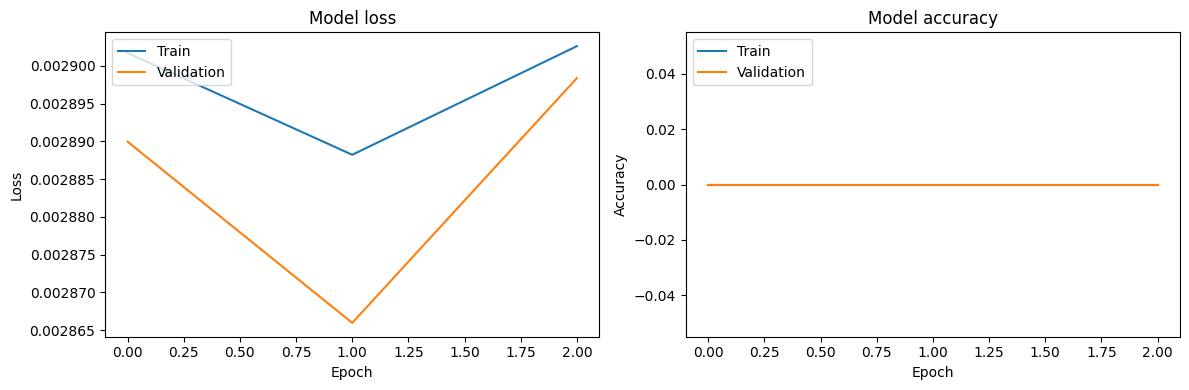

In [206]:
n_epochs = 3
trainer = ModelTrainer(gan, train_generator, val_generator, train_steps, val_steps, epochs=n_epochs, verbose=1)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = trainer.train()
trainer.plot_history()

In [209]:
evaluator = ModelEvaluator(generator, val_generator, val_steps)
evaluator.evaluate()

val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = generator.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

## WGAN

In [ ]:
def res_block(x, filters, stride=1):
    y = Conv2D(filters, kernel_size=3, padding='same', strides=stride, use_bias=False)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Conv2D(filters, kernel_size=3, padding='same', strides=1, use_bias=False)(y)
    y = BatchNormalization()(y)
    
    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=1, strides=stride)(x)
        
    return ReLU()(tf.keras.layers.add([x, y]))

def down_sample_conv(x, filters):
    x = MaxPooling2D(2)(x)
    return res_block(x, filters)

def up_sample_conv(x, skip, filters):
    x = UpSampling2D()(x)
    x = Concatenate()([x, skip])
    return res_block(x, filters)

def build_generator(input_shape=(32, 32, 1), output_channels=2, dropout_rate=0.2):
    inputs = Input(shape=input_shape)

    # Encoder
    e1 = res_block(inputs, 64)
    e1 = Dropout(dropout_rate)(e1)
    e2 = down_sample_conv(e1, 128)
    e2 = Dropout(dropout_rate)(e2)
    e3 = down_sample_conv(e2, 256)
    e3 = Dropout(dropout_rate)(e3)

    # Bridge
    bridge = down_sample_conv(e3, 512)
    bridge = Dropout(dropout_rate)(bridge)

    # Decoder
    d3 = up_sample_conv(bridge, e3, 256)
    d2 = up_sample_conv(d3, e2, 128)
    d1 = up_sample_conv(d2, e1, 64)

    outputs = Conv2D(output_channels, kernel_size=1, activation='sigmoid')(d1)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the generator model
generator = build_generator()
generator.summary()

In [ ]:
def critic_block(inputs, filters, normalization=True):
    x = Conv2D(filters, kernel_size=4, strides=2, padding='same')(inputs)
    if normalization:
        x = InstanceNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_discriminator(input_shape=(32, 32, 2), condition_shape=(32, 32, 1)):
    ab_input = Input(shape=input_shape)
    l_input = Input(shape=condition_shape)
    
    # Concatenate the inputs along the channel axis
    img_input = Concatenate(axis=-1)([ab_input, l_input])

    x = critic_block(img_input, 64, normalization=False)
    x = critic_block(x, 128)
    x = critic_block(x, 256)
    x = critic_block(x, 512)

    x = AveragePooling2D(pool_size=(4, 4))(x)  # Equivalent to nn.AdaptiveAvgPool2d(1)
    x = Flatten()(x)
    x = Dense(1)(x)
    
    model = Model(inputs=[ab_input, l_input], outputs=x)
    return model

discriminator_model = build_discriminator()
discriminator_model.summary()

# Plot the model architecture
tf.keras.utils.plot_model(discriminator_model, show_shapes=True, dpi=64)

In [ ]:
num_epochs = 150

for e in range( num_epochs ):
    print( e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print( x.shape )
        train_step( x , y )

In [ ]:
class CWGAN(pl.LightningModule):

    def __init__(self, in_channels=1, out_channels=2, learning_rate=0.0002, lambda_recon=100, lambda_gp=10, lambda_r1=10):
        super(CWGAN, self).__init__()
        
        self.generator = build_generator(input_shape=(32, 32, 1), output_channels=2)
        self.critic = Critic(in_channels + out_channels)
        
        self.learning_rate = learning_rate
        self.lambda_recon = lambda_recon
        self.lambda_gp = lambda_gp
        self.lambda_r1 = lambda_r1
        self.recon_criterion = nn.L1Loss()
        
        self.generator_losses, self.critic_losses = [], []
    
    def configure_optimizers(self):
        optimizer_G = optim.Adam(self.generator.parameters(), lr=self.learning_rate, betas=(0.5, 0.9))
        optimizer_C = optim.Adam(self.critic.parameters(), lr=self.learning_rate, betas=(0.5, 0.9))
        return [optimizer_C, optimizer_G]

    def generator_step(self, real_images, conditioned_images):
        self.optimizer_G.zero_grad()
        fake_images = self.generator(conditioned_images)
        recon_loss = self.recon_criterion(fake_images, real_images)
        recon_loss.backward()
        self.optimizer_G.step()
        
        self.generator_losses.append(recon_loss.item())

    def critic_step(self, real_images, conditioned_images):
        self.optimizer_C.zero_grad()
        fake_images = self.generator(conditioned_images).detach()
        fake_logits = self.critic(fake_images, conditioned_images)
        real_logits = self.critic(real_images, conditioned_images)
        
        loss_C = real_logits.mean() - fake_logits.mean()

        alpha = torch.rand(real_images.size(0), 1, 1, 1, requires_grad=True).to(self.device)
        interpolated = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
        interpolated_logits = self.critic(interpolated, conditioned_images)
        
        grad_outputs = torch.ones_like(interpolated_logits, requires_grad=True).to(self.device)
        gradients = torch.autograd.grad(
            outputs=interpolated_logits, inputs=interpolated,
            grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True
        )[0]

        gradients = gradients.view(len(gradients), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        loss_C += self.lambda_gp * gradient_penalty
        
        r1_reg = gradients.pow(2).sum(1).mean()
        loss_C += self.lambda_r1 * r1_reg

        loss_C.backward()
        self.optimizer_C.step()
        self.critic_losses.append(loss_C.item())

    def training_step(self, batch, batch_idx, optimizer_idx):
        real, condition = batch
        if optimizer_idx == 0:
            self.critic_step(real, condition)
        elif optimizer_idx == 1:
            self.generator_step(real, condition)

        self.log('gen_loss', torch.tensor(self.generator_losses).mean(), prog_bar=True)
        self.log('crit_loss', torch.tensor(self.critic_losses).mean(), prog_bar=True)

In [ ]:
trainer = ModelTrainer(ae_vgg_model, train_generator, val_generator, train_steps, val_steps, epochs=30)
#trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = trainer.train()
trainer.plot_history()

In [ ]:
evaluator = ModelEvaluator(ae_vgg_model, val_generator, val_steps)
evaluator.evaluate()

In [ ]:
val_l_batch, val_ab_batch = next(val_generator)
predicted_ab = ae_vgg_model.predict(val_l_batch)

plot_lab_and_rgb_images(val_l_batch, val_ab_batch, num_samples=3)
print()
plot_lab_and_rgb_images(val_l_batch, predicted_ab, predicted_ab, num_samples=3)

In [ ]:
val_l_batches, val_ab_batches = take_x_batches(val_generator, 4)

predicted_ab = ae_vgg_model.predict(val_l_batches)
plot_lab_images(val_l_batches, val_ab_batches, imgs_in_row=16, title=f'Batch of {len(val_l_batches)} original color images')
plot_lab_images(val_l_batches, predicted_ab, imgs_in_row=16, title=f'Batch of {len(val_l_batches)} predicted color images')

## Fusion

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_120 (InputLayer)         [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_350 (Conv2D)            (None, 32, 32, 128)  1280        ['input_120[0][0]']              
                                                                                                  
 max_pooling2d_78 (MaxPooling2D  (None, 16, 16, 128)  0          ['conv2d_350[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_351 (Conv2D)            (None, 16, 16, 128)  262272      ['max_pooling2d_78[0][0]']

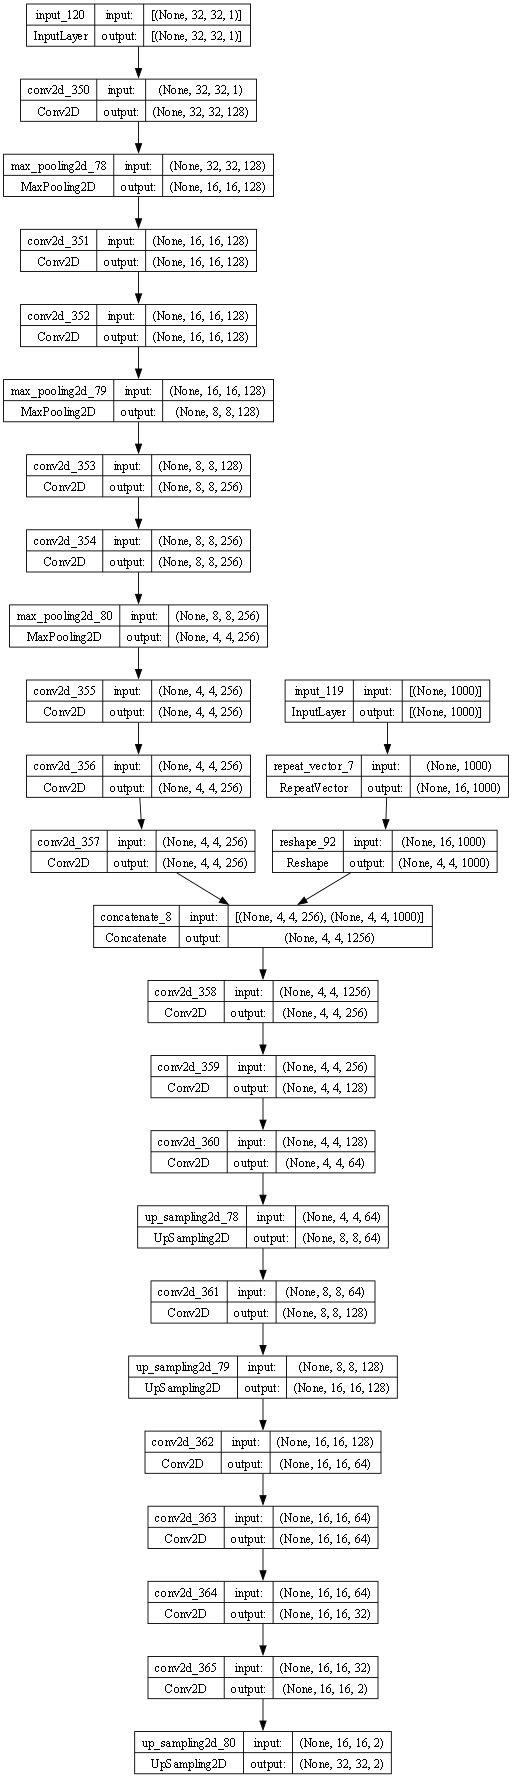

In [310]:
from keras.layers import RepeatVector

def Colorize(input_shape=(32, 32, 1)):
    embed_input = Input(shape=(1000,))
    
    # Encoder
    encoder_input = Input(shape=input_shape)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)  # 16x16
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)  # 8x8
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)  # 4x4
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    # Fusion
    fusion_output = RepeatVector(4 * 4)(embed_input) 
    fusion_output = Reshape((4, 4, 1000))(fusion_output)
    fusion_output = Concatenate(axis=3)([encoder_output, fusion_output]) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    # Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)  # 8x8
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)  # 16x16
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)  # 32x32

    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [311]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

def image_a_b_gen(dataset=X_train, batch_size = 50):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch


trainer = ModelTrainer(model, train_generator, val_generator, train_steps, val_steps, epochs=30)
trainer.compile_model(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', ssim])
history = trainer.train()
trainer.plot_history()

225209952/225209952 [==============================] - 67s 0us/step


AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

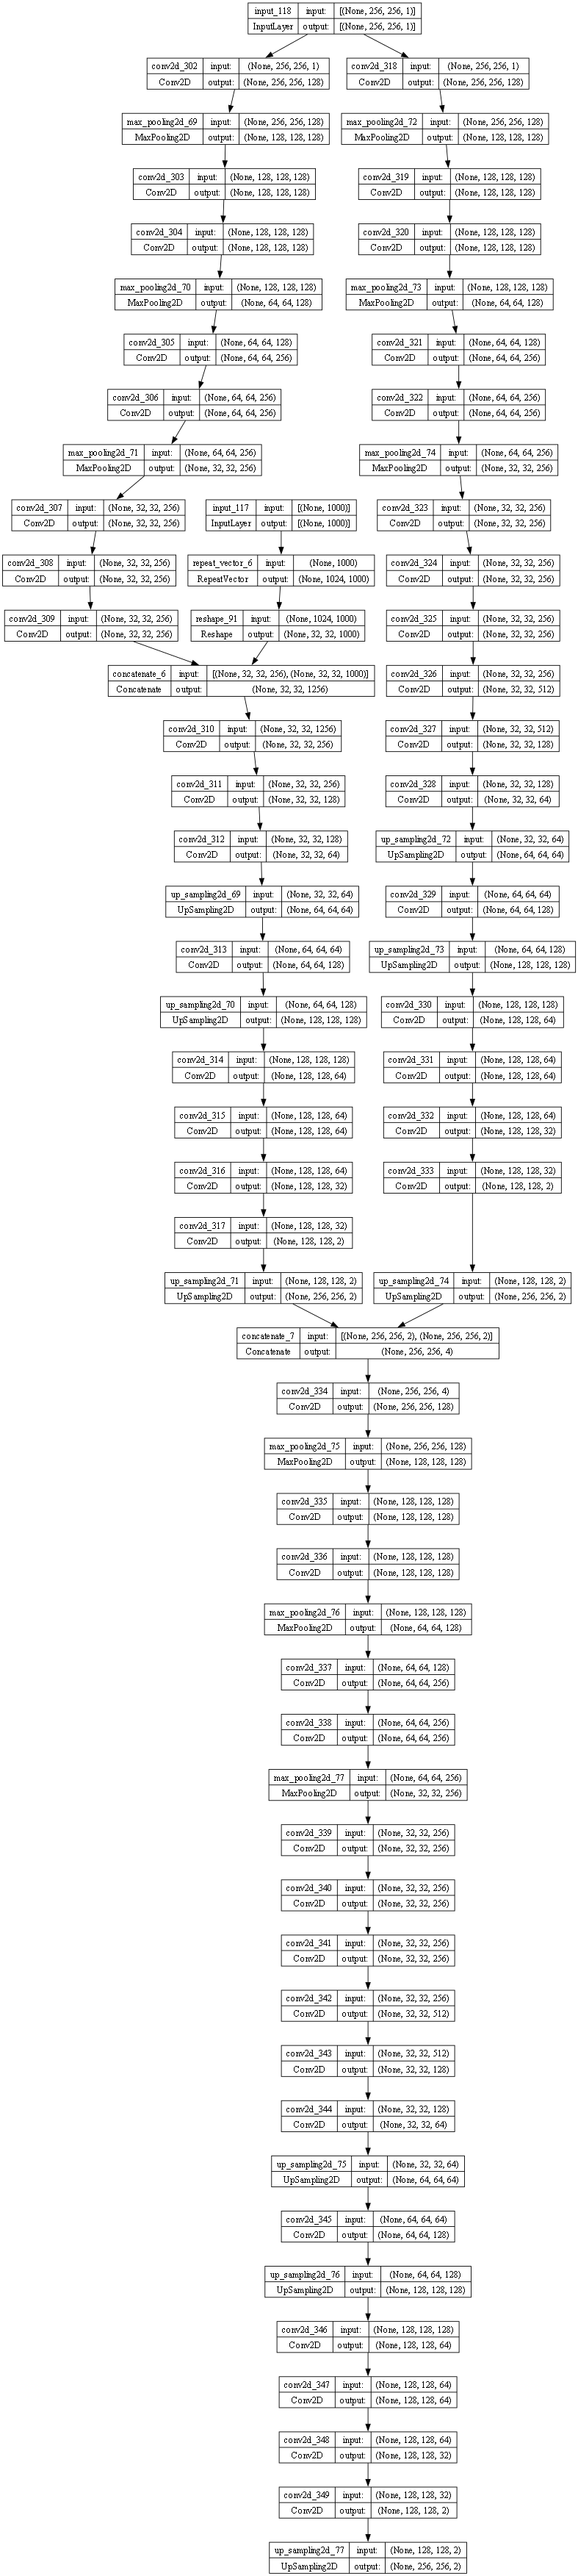

In [305]:
def Colorize():
    embed_input = Input(shape=(1000,))
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = Concatenate(axis=3)([encoder_output, fusion_output]) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)

    encoder_output_2 = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output_2 = MaxPooling2D((2, 2), padding='same')(encoder_output_2)
    encoder_output_2 = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output_2)
    encoder_output_2 = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output_2)
    encoder_output_2 = MaxPooling2D((2, 2), padding='same')(encoder_output_2)
    encoder_output_2 = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output_2)
    encoder_output_2 = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output_2)
    encoder_output_2 = MaxPooling2D((2, 2), padding='same')(encoder_output_2)
    encoder_output_2 = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output_2)
    encoder_output_2 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output_2)
    encoder_output_2 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output_2)
    
    #Fusion
    fusion_output_2 = Conv2D(512, (1, 1), activation='relu', padding='same')(encoder_output_2)
    
    #Decoder
    decoder_output_2 = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output_2)
    decoder_output_2 = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output_2)
    decoder_output_2 = UpSampling2D((2, 2))(decoder_output_2)
    decoder_output_2 = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output_2)
    decoder_output_2 = UpSampling2D((2, 2))(decoder_output_2)
    decoder_output_2 = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output_2)
    decoder_output_2 = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output_2)
    decoder_output_2 = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output_2)
    decoder_output_2 = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output_2)
    decoder_output_2 = UpSampling2D((2, 2))(decoder_output_2)

    encoder_input_3 = Concatenate(axis=3)([decoder_output, decoder_output_2])
    encoder_output_3 = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input_3)
    encoder_output_3 = MaxPooling2D((2, 2), padding='same')(encoder_output_3)
    encoder_output_3 = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output_3)
    encoder_output_3 = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output_3)
    encoder_output_3 = MaxPooling2D((2, 2), padding='same')(encoder_output_3)
    encoder_output_3 = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output_3)
    encoder_output_3 = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output_3)
    encoder_output_3 = MaxPooling2D((2, 2), padding='same')(encoder_output_3)
    encoder_output_3 = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output_3)
    encoder_output_3 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output_3)
    encoder_output_3 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output_3)
    
    #Fusion
    fusion_output_3 = Conv2D(512, (1, 1), activation='relu', padding='same')(encoder_output_3)
    
    #Decoder
    decoder_output_3 = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output_3)
    decoder_output_3 = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output_3)
    decoder_output_3 = UpSampling2D((2, 2))(decoder_output_3)
    decoder_output_3 = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output_3)
    decoder_output_3 = UpSampling2D((2, 2))(decoder_output_3)
    decoder_output_3 = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output_3)
    decoder_output_3 = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output_3)
    decoder_output_3 = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output_3)
    decoder_output_3 = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output_3)
    decoder_output_3 = UpSampling2D((2, 2))(decoder_output_3)

    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output_3)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

# Model comparison

In [ ]:
model_list = [
    (simple_model, "simple_model"),
    (unet_model, "unet maxpool"),
    (unet_model_2, "unet avgpool"),
    (unet_model_3, "unet skip connection"),
    (ae_64_model, "ae_64_model"),
    (ae_256_model, "ae_256_model"),
    (ae_256_bn_model, "ae_256_bn_model"),
    (ae_vgg_model, "ae_vgg_model"),
    (rnn128_model, "rnn128_model"),
    (rnn256_model, "rnn256_model"),
    (rnn512_model, "rnn512_model")
]

In [ ]:
test_l_batches, test_ab_batches = take_x_batches(test_generator, 4)
plot_lab_images(test_l_batches, test_ab_batches, imgs_in_row=16, title='original images')

for (model, model_name) in model_list:
    predicted_ab = rnn512_model.predict(test_l_batches)
    title = model_name + "\n" + f'Batch of {len(test_l_batches)} '
    plot_lab_images(test_l_batches, predicted_ab, imgs_in_row=16, title= title + 'predicted color images')
    print()

# Load and colorize user's images

In [ ]:
path = './example_imgs/'

loaded_images = load_img_from_path(path, img_size=(32, 32))
imgs_l, imgs_ab = preprocess_color_images_to_lab(loaded_images)
imgs_num = len(imgs_l)

plot_lab_images(imgs_l, imgs_ab, imgs_in_row=min(imgs_num, 10), title='original images')


for (model, model_name) in model_list:
    predicted_ab = rnn512_model.predict(imgs_l)
    plot_lab_images(imgs_l, predicted_ab, imgs_in_row=min(imgs_num, 10), title= model_name + '\npredicted color images')
    print()

## Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class ImageProcessingPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, model_list):
        self.model_list = model_list
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        loaded_images = load_img_from_path(X)
        imgs_l, imgs_ab = preprocess_color_images_to_lab(loaded_images)
        
        imgs_num = len(imgs_l)
        
        for model, model_name in self.model_list:
            predicted_ab = model.predict(imgs_l)
            plot_lab_images(imgs_l, predicted_ab, imgs_in_row=min(imgs_num, 10), title=model_name + '\npredicted color images')
        
        return imgs_l, imgs_ab

path = './example_imgs/'
pipeline = Pipeline([
    ('image_processing', ImageProcessingPipeline(model_list))
])

pipeline.fit(path)

# Enhanced Deep Residual Networks for single-image super-resolution

https://keras.io/examples/vision/edsr/